<a href="https://colab.research.google.com/github/Pocho01/ProyectoCapstone/blob/main/ProyectoCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modelos de aprendizaje supervisado para el número de matrículas estudiantiles en Ecuador**


El presente notebook tiene como finalidad desarrollar e implementar diversos modelos de aprendizaje supervisado para estimar con alta precisión el número total de estudiantes matriculados en Ecuador, a partir de datos históricos. Para ello, se llevará a cabo un proceso integral que incluye la limpieza y preprocesamiento de datos, el análisis exploratorio (EDA), la selección de características relevantes, y la construcción, entrenamiento y evaluación comparativa de modelos de regresión. El objetivo final es identificar el modelo que proporcione el mejor desempeño predictivo, basado en métricas como RMSE y error relativo, con miras a su posible implementación en escenarios de planificación educativa y toma de decisiones a nivel nacional.

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# Widgets interactivos y entorno Jupyter
import ipywidgets as widgets
from IPython.display import display

# Modelado estadístico
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelos de machine learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Preprocesamiento y evaluación
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Cargar archivo (ajusta el nombre si trabajas localmente)
from google.colab import drive, files
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/registro-administrativo-historico_2009-2024-inicio.csv', sep=';', thousands='.', low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Mostrar las primeras filas del DataFrame para una vista previa de los datos.
df.head()

,Anio_lectivo,Zona,Provincia,Cod_Provincia,Canton,Cod_Canton,Parroquia,Cod_Parroquia,Nombre_Institucion,AMIE,...,Total_Docentes,Estudiantes_Femenino,Estudiantes_Masculino,Total_Estudiantes,Ecuatoriana,Colombiana,Venezolana,Peruana,Otros_Paises_de_America,Otros_Continentes
0,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,EL SAGRARIO,10104.0,UNIDAD EDUCATIVA PARTICULAR ROSA DE JESUS CORDERO,01B00002,...,96.0,1473.0,0.0,1473.0,1455,0,0,0,18,0
1,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,MONAY,10109.0,CEBCI,01B00010,...,25.0,148.0,179.0,327.0,311,3,0,0,9,4
2,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,CENTRO EDUCATIVO ROUSSEAU,01B00019,...,10.0,17.0,23.0,40.0,39,0,0,0,1,0
3,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,COLEGIO INTERCULTURAL BILINGUE DE NARANCAY,01B00020,...,17.0,132.0,132.0,264.0,264,0,0,0,0,0
4,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,CHAUCHA,10153.0,SEIS DE JUNIO,01B00021,...,1.0,18.0,6.0,24.0,24,0,0,0,0,0


In [4]:
#Mostrar información general del DataFrame: número de filas, columnas, tipos de datos y valores no nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442716 entries, 0 to 442715
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anio_lectivo             322602 non-null  object 
 1   Zona                     322602 non-null  object 
 2   Provincia                322602 non-null  object 
 3   Cod_Provincia            322602 non-null  float64
 4   Canton                   322602 non-null  object 
 5   Cod_Canton               322602 non-null  float64
 6   Parroquia                322602 non-null  object 
 7   Cod_Parroquia            322602 non-null  float64
 8   Nombre_Institucion       322602 non-null  object 
 9   AMIE                     322602 non-null  object 
 10  Tipo_Educacion           322602 non-null  object 
 11  Sostenimiento            322602 non-null  object 
 12  Area                     322602 non-null  object 
 13  Regimen_Escolar          322602 non-null  object 
 14  Juri

In [5]:
# Crear una copia de trabajo del DataFrame original para realizar las modificaciones de limpieza y preprocesamiento.
df_clean = df.copy()

In [6]:
# Convertir 'Anio_lectivo' a solo el año de inicio
df_clean = df_clean[df_clean['Anio_lectivo'].notnull()].copy()
df_clean['Anio_Inicio'] = df_clean['Anio_lectivo'].str.extract(r'(\d{4})').astype(int)
# Eliminar la columna original 'Anio_lectivo'
df_clean = df_clean.drop('Anio_lectivo', axis=1)

In [7]:
# Seleccionar columnas tipo float
float_cols = df_clean.select_dtypes(include=['float']).columns

# Convertir columnas flotantes a enteros (si es posible sin perder información)
for col in float_cols:
    # Verificar si la columna contiene solo valores enteros representados como float
    if (df_clean[col] == df_clean[col].astype(int)).all():
        df_clean[col] = df_clean[col].astype(int)
    else:
        print(f"La columna '{col}' contiene valores no enteros y no se puede convertir a int sin pérdida.")

In [8]:
#Estandarizar columnas de texto
text_columns = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

for col in text_columns:
    df_clean[col] = df_clean[col].str.strip().str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [9]:
# Lista de columnas categóricas a codificar
vars_to_encode = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Codificación one-hot (dummies), eliminando la primera categoría para evitar multicolinealidad
df_clean = pd.get_dummies(df_clean, columns=vars_to_encode, drop_first=True)

In [10]:
# Lista de columnas de interés, incluyendo las originales y las codificadas
# Las columnas codificadas tendrán prefijos basados en los nombres originales
# de las columnas categóricas
columns_of_interest = [
    'Cod_Provincia',
    'Total_Docentes',
    'Total_Estudiantes',
    'Anio_Inicio'
]

# Agregar dinámicamente las columnas codificadas a la lista de interés
# Iteramos sobre las columnas de df_clean y agregamos aquellas que son resultado de get_dummies
for col in df_clean.columns:
    # Comprobamos si la columna comienza con alguno de los prefijos de las variables codificadas
    if any(col.startswith(prefix + '_') for prefix in vars_to_encode):
        columns_of_interest.append(col)

# Crear un nuevo DataFrame con las columnas seleccionadas
df_selected = df_clean[columns_of_interest].copy()

# Mostrar información del nuevo DataFrame para verificar los tipos de datos y columnas
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Index: 322602 entries, 0 to 322601
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   Cod_Provincia                        322602 non-null  int64
 1   Total_Docentes                       322602 non-null  int64
 2   Total_Estudiantes                    322602 non-null  int64
 3   Anio_Inicio                          322602 non-null  int64
 4   Tipo_Educacion_ordinario             322602 non-null  bool 
 5   Tipo_Educacion_popular permanente    322602 non-null  bool 
 6   Sostenimiento_fiscomisional          322602 non-null  bool 
 7   Sostenimiento_municipal              322602 non-null  bool 
 8   Sostenimiento_particular             322602 non-null  bool 
 9   Area_urbana                          322602 non-null  bool 
 10  Regimen_Escolar_sierra               322602 non-null  bool 
 11  Jurisdiccion_intercultural bilingue  322602 

In [11]:
# Eliminamos la provincia 90 de nuestro dataframe por falta de registros en algunos años
df_selected = df_selected[df_selected['Cod_Provincia'] != 90].copy()

In [12]:
# Crear copia de df_selected
df_new = df_selected.copy()

In [13]:
#Convertir el año en un índice de tipo datetime
df_selected['Anio'] = pd.to_datetime(df_selected['Anio_Inicio'], format='%Y')
df_selected.set_index('Anio', inplace=True)

# Eliminar la columna Anio_Inicio
df_selected.drop(columns='Anio_Inicio', inplace=True)

In [14]:
# Mostrar las primeras filas del DataFrame con el índice de tiempo.
df_selected.head()

,Cod_Provincia,Total_Docentes,Total_Estudiantes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue
Anio,,,,,,,,,,,
2009-01-01,1,96,1473,True,False,False,False,True,True,True,False
2009-01-01,1,25,327,True,False,False,False,True,True,True,True
2009-01-01,1,10,40,True,False,False,False,True,False,True,True
2009-01-01,1,17,264,True,False,False,False,False,False,True,True
2009-01-01,1,1,24,True,False,False,False,False,False,False,True


In [15]:
#Mostrar estadísticas descriptivas para las columnas 'Total_Docentes' y 'Total_Estudiantes'.
df_selected[["Total_Docentes", "Total_Estudiantes"]].describe()

,Total_Docentes,Total_Estudiantes
count,321878.000000,321878.000000
mean,10.938582,218.183100
std,18.071431,410.068347
min,0.000000,1.000000
25%,1.000000,21.000000
50%,4.000000,58.000000
75%,13.000000,222.000000
max,374.000000,9463.000000


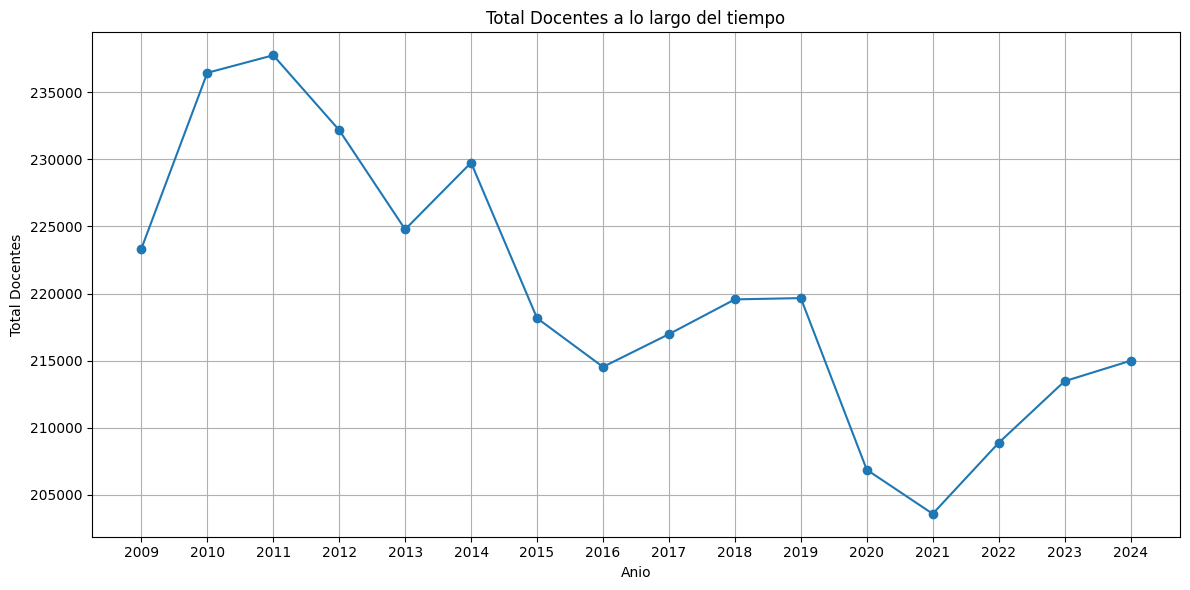

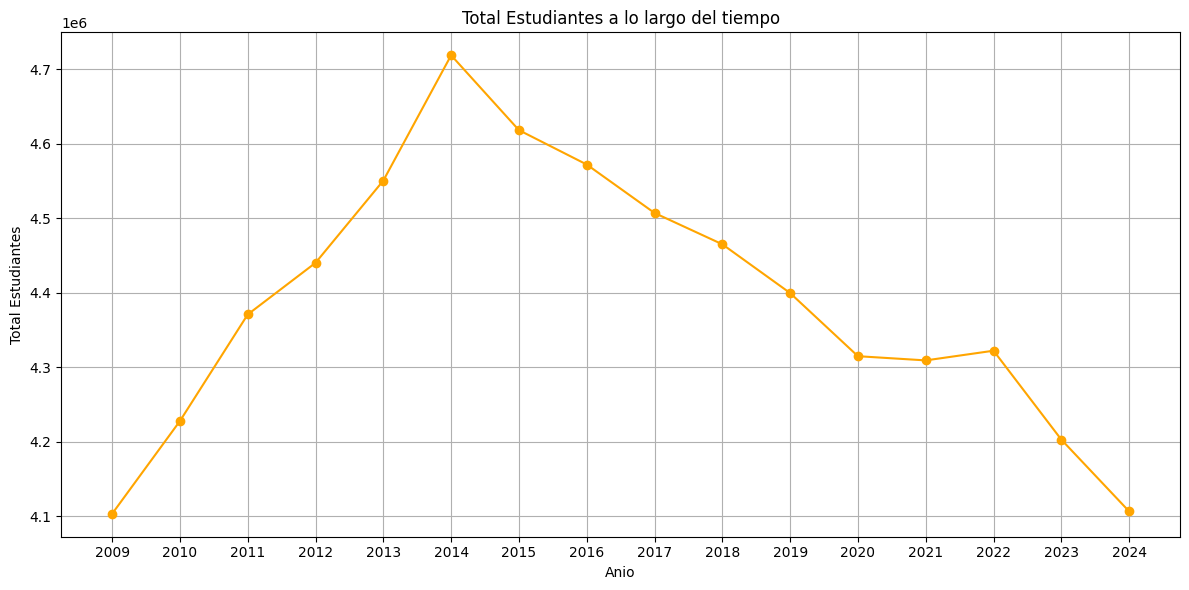

In [16]:
# Agrupar por año y sumar 'Total_Docentes' y 'Total_Estudiantes'
df_yearly_totals = df_selected.groupby('Anio')[['Total_Docentes', 'Total_Estudiantes']].sum()

# Graficar Total_Docentes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Docentes'], marker='o', linestyle='-')
plt.title('Total Docentes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Docentes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

# Graficar Total_Estudiantes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Estudiantes'], marker='o', linestyle='-', color='orange')
plt.title('Total Estudiantes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Estudiantes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

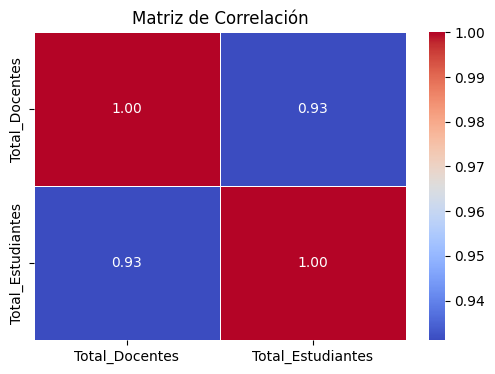

In [17]:
# Calcular la correlación entre 'Total_Docentes' y 'Total_Estudiantes'
corr = df_selected[["Total_Docentes", "Total_Estudiantes"]].corr()

# Dibujar un heatmap de la matriz de correlación.
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

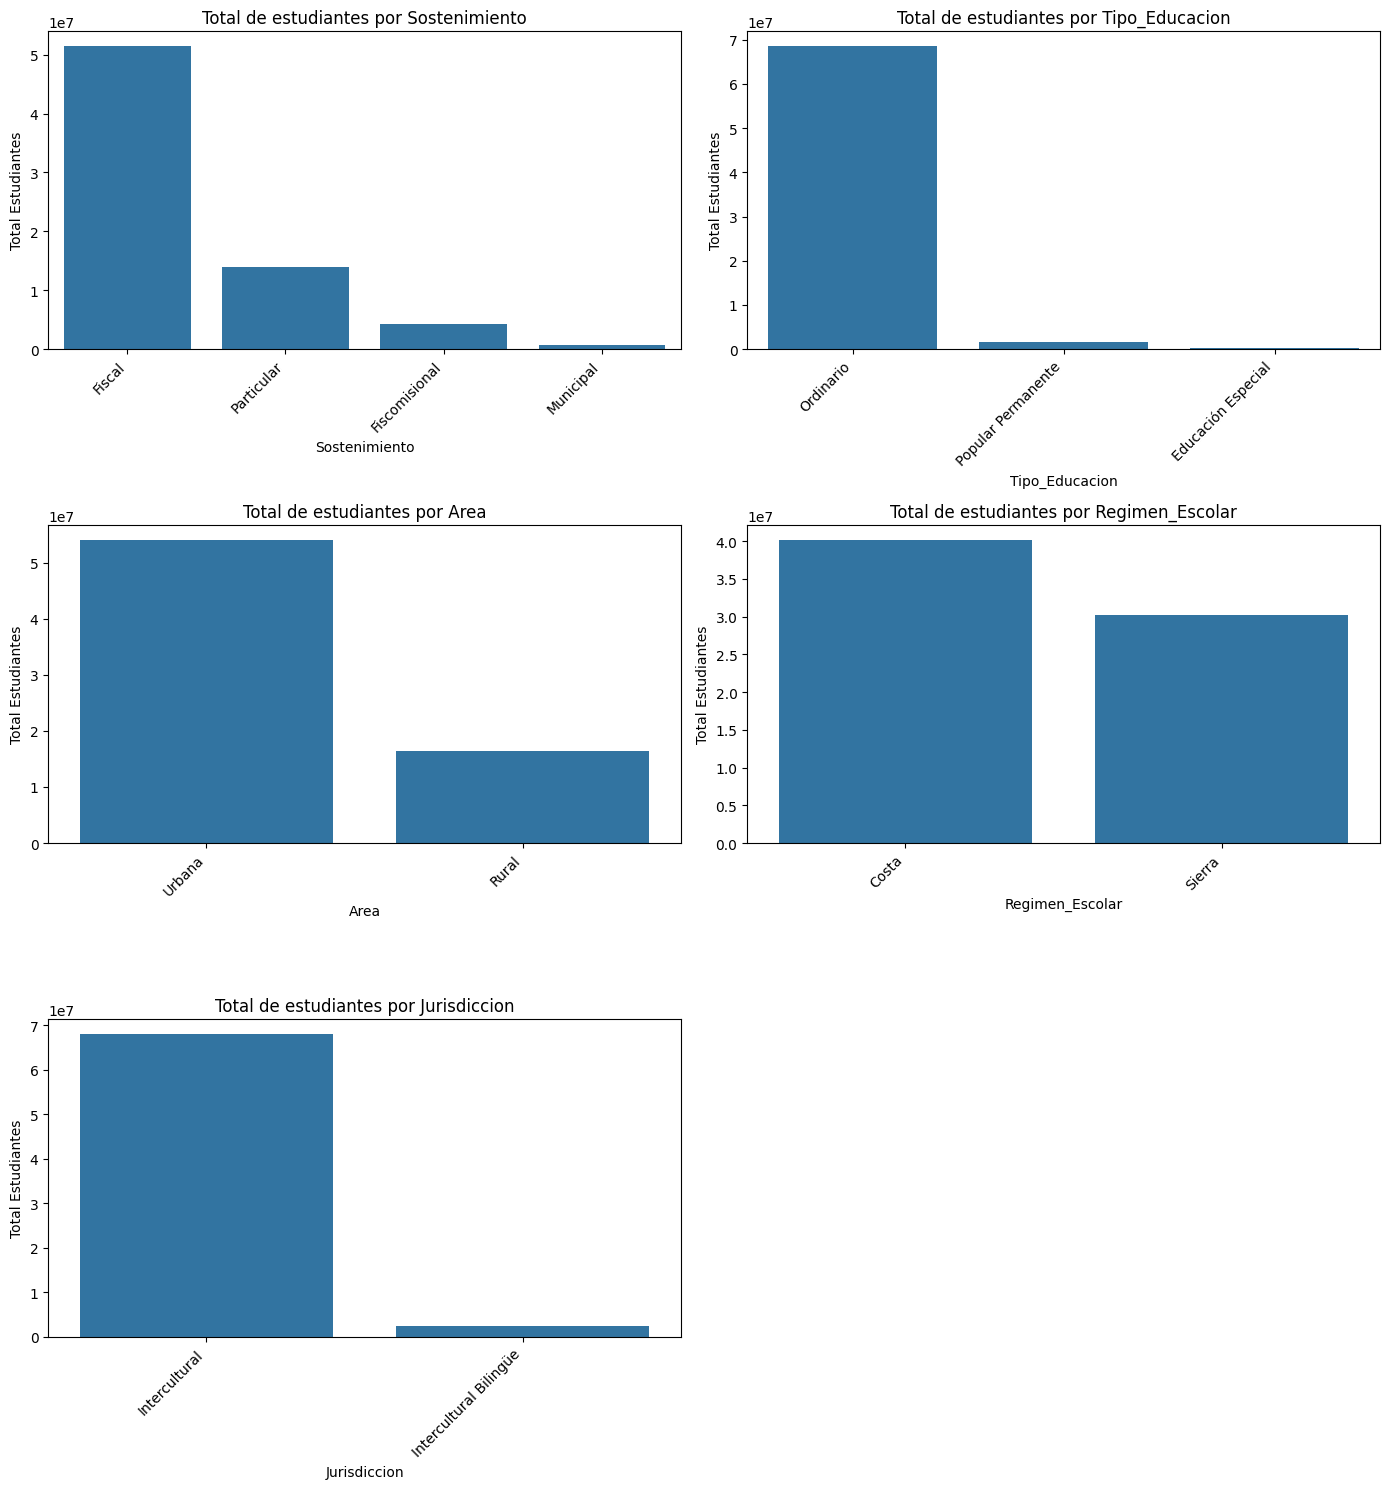

In [18]:
# Variables categóricas para visualización.
categorical_vars = ['Sostenimiento', 'Tipo_Educacion', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Configurar subplots para graficar cada variable categórica por separado.
n = len(categorical_vars)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Graficar el total de estudiantes por cada variable categórica.
for i, var in enumerate(categorical_vars):
    df_viz = df.groupby(var)['Total_Estudiantes'].sum().reset_index().sort_values(by='Total_Estudiantes', ascending=False)

    sns.barplot(data=df_viz, x=var, y='Total_Estudiantes', ax=axes[i])
    axes[i].set_title(f'Total de estudiantes por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Total Estudiantes')

    # Rotar etiquetas de eje x correctamente
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Eliminar subplots vacíos si hay más ejes que variables categóricas.
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
# Lista de columnas que se van a sumar (totales por provincia y año)
cols_sum = ['Total_Estudiantes', 'Total_Docentes']
# Lista de columnas a las que se les calculará el promedio (columnas dummy creadas por get_dummies).
# Se excluyen las columnas de suma y las columnas de identificación/tiempo.
cols_mean = [col for col in df_new.columns if col not in ['Cod_Provincia', 'Anio_Inicio'] + cols_sum]


# Agrupamos por Cod_Provincia y Anio_Inicio y sumamos las columnas especificadas
df_agg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_sum].sum().reset_index()
# Agrupamos por Cod_Provincia y Anio_Inicio y calculamos el promedio de las columnas dummy.
df_dummy_avg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_mean].mean().reset_index()

# Unimos los resultados de las agrupaciones por provincia y año.
df_final = pd.merge(df_agg, df_dummy_avg, on=['Cod_Provincia', 'Anio_Inicio'])

In [20]:
# Crear variables de retraso (lags) para 'Total_Estudiantes'.
# Se crean lags de 1 a 3 años para capturar la dependencia temporal.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final.groupby('Cod_Provincia')['Total_Estudiantes'].shift(i)

# Eliminar las filas que contienen valores nulos debido a los lags (las primeras filas de cada provincia).
df_final = df_final.dropna().reset_index(drop=True)

# Convertir las columnas de lag a tipo entero.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final[f'Total_Estudiantes_lag{i}'].astype(int)


In [21]:
# Mostrar las primeras filas del DataFrame final con las columnas de lag.
df_final.head()

,Cod_Provincia,Anio_Inicio,Total_Estudiantes,Total_Docentes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue,Total_Estudiantes_lag1,Total_Estudiantes_lag2,Total_Estudiantes_lag3
0,1,2012,213675,11568,0.923077,0.065295,0.062612,0.010733,0.173524,0.503578,0.759392,0.035778,211092,203494,199677
1,1,2013,219571,11791,0.955366,0.032289,0.029440,0.009497,0.189934,0.503324,0.776828,0.037037,213675,211092,203494
2,1,2014,222499,11703,0.957086,0.030938,0.036926,0.009980,0.181637,0.498004,0.773453,0.035928,219571,213675,211092
3,1,2015,221404,11398,0.955319,0.031915,0.040426,0.011702,0.192553,0.511702,0.768085,0.035106,222499,219571,213675
4,1,2016,218808,11004,0.959954,0.026316,0.044622,0.011442,0.187643,0.525172,0.763158,0.034325,221404,222499,219571


In [22]:
# Obtener la lista de códigos de provincia únicos del DataFrame final
provinces = df_final['Cod_Provincia'].unique()

# Diccionario para almacenar las ventanas por provincia
province_data_splits = {}

# Iterar a través de cada provincia única
for cod_provincia in provinces:
    # Filtrar los datos de esa provincia
    df_prov = df_final[df_final['Cod_Provincia'] == cod_provincia].copy()

    # Ordenar por año para mantener la secuencia temporal
    df_prov = df_prov.sort_values(by="Anio_Inicio")

    # Separar X e y
    X_all = df_prov.drop(columns=["Total_Estudiantes"])
    y_all = df_prov["Total_Estudiantes"]

    # Inicializar lista de ventanas para esta provincia
    ventanas = []

    # Iterar por cada punto del tiempo a partir de la segunda observación
    for i in range(1, len(df_prov)):
        # Entrenamiento hasta el año i-1
        X_train = X_all.iloc[:i].reset_index(drop=True)
        y_train = y_all.iloc[:i].reset_index(drop=True)

        # Prueba: predicción para el siguiente año
        X_test = X_all.iloc[i:i+1].reset_index(drop=True)
        y_test = y_all.iloc[i:i+1].reset_index(drop=True)

        # Guardar la ventana en la lista
        ventanas.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        })

    # Guardar todas las ventanas de esta provincia
    province_data_splits[cod_provincia] = ventanas

print("\nVentanas tipo 'rolling forecasting' generadas para todas las provincias y almacenadas en 'province_data_splits'.")



Ventanas tipo 'rolling forecasting' generadas para todas las provincias y almacenadas en 'province_data_splits'.


In [23]:
# Diccionarios para almacenar resultados
xgbr_models_por_provincia = {}
xgbr_predictions_por_provincia = {}
xgbr_evaluacion_por_provincia = {}

# Iterar por cada provincia y sus ventanas
for cod_provincia, ventanas in province_data_splits.items():
    modelos = []
    predicciones = []
    reales = []
    errores_relativos = []

    for i, ventana in enumerate(ventanas):
        X_train = ventana['X_train']
        y_train = ventana['y_train']
        X_test = ventana['X_test']
        y_test = ventana['y_test']

        # Verificar que no haya valores vacíos
        if not X_train.empty and not X_test.empty:
            # Entrenar el modelo XGBoost
            modelo = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
            modelo.fit(X_train, y_train)

            # Predecir
            y_pred = modelo.predict(X_test)

            # Almacenar modelo y predicción
            modelos.append(modelo)
            predicciones.extend(y_pred.tolist())
            reales.extend(y_test.tolist())

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            media_real = np.mean(y_test)
            error_relativo = (rmse / media_real) * 100 if media_real != 0 else float('inf')

            errores_relativos.append(error_relativo)


    # Guardar resultados promedio si hubo al menos una ventana válida
    if errores_relativos:
        xgbr_models_por_provincia[cod_provincia] = modelos
        xgbr_predictions_por_provincia[cod_provincia] = {
            "Predicciones": predicciones,
            "Reales": reales
        }
        xgbr_evaluacion_por_provincia[cod_provincia] = {
            'RMSE promedio': np.sqrt(mean_squared_error(reales, predicciones)),
            'Error Relativo (%) promedio': np.mean(errores_relativos)
        }

# Ordenar por menor error relativo promedio
resultados_xgbr_ordenados = sorted(xgbr_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%) promedio'])

# Imprimir resumen
print("\nResumen Final de Evaluación de XGBoost por Provincia (ordenado por Error Relativo promedio):")
for cod_provincia, metrics in resultados_xgbr_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE promedio']:.2f}, Error Relativo = {metrics['Error Relativo (%) promedio']:.2f}%")

# Mejor provincia
if resultados_xgbr_ordenados:
    mejor_provincia = resultados_xgbr_ordenados[0]
    print(f"\n✅ La provincia con el menor error relativo promedio es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%) promedio']:.2f}%")
else:
    print("\n❌ No se pudieron calcular métricas de evaluación para ninguna provincia.")



Resumen Final de Evaluación de XGBoost por Provincia (ordenado por Error Relativo promedio):
Provincia Código 14: RMSE = 866.11, Error Relativo = 1.12%
Provincia Código 19: RMSE = 558.99, Error Relativo = 1.35%
Provincia Código 7: RMSE = 3445.03, Error Relativo = 1.59%
Provincia Código 13: RMSE = 7674.75, Error Relativo = 1.67%
Provincia Código 18: RMSE = 2598.30, Error Relativo = 1.67%
Provincia Código 11: RMSE = 2690.99, Error Relativo = 1.98%
Provincia Código 3: RMSE = 1694.63, Error Relativo = 2.05%
Provincia Código 17: RMSE = 18463.17, Error Relativo = 2.06%
Provincia Código 6: RMSE = 3057.97, Error Relativo = 2.14%
Provincia Código 12: RMSE = 6435.91, Error Relativo = 2.16%
Provincia Código 10: RMSE = 3742.25, Error Relativo = 2.21%
Provincia Código 1: RMSE = 5507.10, Error Relativo = 2.21%
Provincia Código 4: RMSE = 1211.60, Error Relativo = 2.27%
Provincia Código 20: RMSE = 202.34, Error Relativo = 2.27%
Provincia Código 23: RMSE = 4467.03, Error Relativo = 2.40%
Provincia Cód

In [24]:
# Diccionarios para almacenar resultados
gbr_models_por_provincia = {}
gbr_predictions_por_provincia = {}
gbr_evaluacion_por_provincia = {}

# Iterar por cada provincia y sus ventanas
for cod_provincia, ventanas in province_data_splits.items():
    modelos = []
    predicciones = []
    reales = []
    errores_relativos = []

    for i, ventana in enumerate(ventanas):
        X_train = ventana['X_train']
        y_train = ventana['y_train']
        X_test = ventana['X_test']
        y_test = ventana['y_test']

        # Verificar que no haya valores vacíos
        if not X_train.empty and not X_test.empty:
            # Entrenar el modelo GradientBoostingRegressor
            modelo = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
            modelo.fit(X_train, y_train)

            # Predecir
            y_pred = modelo.predict(X_test)

            # Almacenar modelo y predicción
            modelos.append(modelo)
            predicciones.extend(y_pred.tolist())
            reales.extend(y_test.tolist())

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            media_real = np.mean(y_test)
            error_relativo = (rmse / media_real) * 100 if media_real != 0 else float('inf')

            errores_relativos.append(error_relativo)


    # Guardar resultados promedio si hubo al menos una ventana válida
    if errores_relativos:
        gbr_models_por_provincia[cod_provincia] = modelos
        gbr_predictions_por_provincia[cod_provincia] = {
            "Predicciones": predicciones,
            "Reales": reales
        }
        gbr_evaluacion_por_provincia[cod_provincia] = {
            'RMSE promedio': np.sqrt(mean_squared_error(reales, predicciones)),
            'Error Relativo (%) promedio': np.mean(errores_relativos)
        }

# Ordenar por menor error relativo promedio
resultados_gbr_ordenados = sorted(gbr_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%) promedio'])

# Imprimir resumen
print("\nResumen Final de Evaluación de GradientBoostingRegressor por Provincia (ordenado por Error Relativo promedio):")
for cod_provincia, metrics in resultados_gbr_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE promedio']:.2f}, Error Relativo = {metrics['Error Relativo (%) promedio']:.2f}%")

# Mejor provincia
if resultados_gbr_ordenados:
    mejor_provincia = resultados_gbr_ordenados[0]
    print(f"\n✅ La provincia con el menor error relativo promedio es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%) promedio']:.2f}%")
else:
    print("\n❌ No se pudieron calcular métricas de evaluación para ninguna provincia.")



Resumen Final de Evaluación de GradientBoostingRegressor por Provincia (ordenado por Error Relativo promedio):
Provincia Código 14: RMSE = 835.78, Error Relativo = 1.00%
Provincia Código 19: RMSE = 675.39, Error Relativo = 1.71%
Provincia Código 13: RMSE = 7822.66, Error Relativo = 1.72%
Provincia Código 7: RMSE = 3772.12, Error Relativo = 1.77%
Provincia Código 21: RMSE = 1813.27, Error Relativo = 2.12%
Provincia Código 20: RMSE = 225.52, Error Relativo = 2.17%
Provincia Código 12: RMSE = 6806.07, Error Relativo = 2.41%
Provincia Código 16: RMSE = 1064.21, Error Relativo = 2.46%
Provincia Código 9: RMSE = 36457.38, Error Relativo = 2.49%
Provincia Código 18: RMSE = 4079.70, Error Relativo = 2.49%
Provincia Código 10: RMSE = 3841.69, Error Relativo = 2.56%
Provincia Código 22: RMSE = 1756.34, Error Relativo = 2.60%
Provincia Código 24: RMSE = 3413.27, Error Relativo = 2.68%
Provincia Código 1: RMSE = 6296.23, Error Relativo = 2.72%
Provincia Código 6: RMSE = 4165.49, Error Relativo = 

In [25]:
# Diccionarios para almacenar resultados
rf_models_por_provincia = {}
rf_predictions_por_provincia = {}
rf_evaluacion_por_provincia = {}

# Iterar sobre cada provincia
for cod_provincia, ventanas in province_data_splits.items():
    evaluaciones_ventanas = []
    predicciones_ventanas = []

    for idx, ventana in enumerate(ventanas):
        X_train = ventana['X_train']
        y_train = ventana['y_train']
        X_test = ventana['X_test']
        y_test = ventana['y_test']

        if not X_train.empty and not X_test.empty:
            # Entrenar modelo Random Forest
            rf_model = RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
            rf_model.fit(X_train, y_train)

            # Predecir para la ventana actual
            y_pred = rf_model.predict(X_test)
            predicciones_ventanas.append(y_pred[0])  # Solo un valor por ventana

            # Evaluación
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            media_real = np.mean(y_test)
            error_relativo = (rmse / media_real) * 100 if media_real != 0 else float('inf')

            evaluaciones_ventanas.append({
                'RMSE': rmse,
                'Error Relativo (%)': error_relativo
            })

    # Almacenar el último modelo entrenado para esta provincia
    if rf_model is not None:
        rf_models_por_provincia[cod_provincia] = rf_model

    # Almacenar predicciones por provincia
    rf_predictions_por_provincia[cod_provincia] = predicciones_ventanas

    # Promediar métricas si hay evaluaciones disponibles
    if evaluaciones_ventanas:
        promedio_rmse = np.mean([e['RMSE'] for e in evaluaciones_ventanas])
        promedio_error_relativo = np.mean([e['Error Relativo (%)'] for e in evaluaciones_ventanas])

        rf_evaluacion_por_provincia[cod_provincia] = {
            'RMSE Promedio': promedio_rmse,
            'Error Relativo Promedio (%)': promedio_error_relativo
        }

# Ordenar resultados por Error Relativo Promedio
resultados_rf_ordenados = sorted(rf_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo Promedio (%)'])

# Mostrar resumen
print("\nResumen Final de Evaluación de Random Forest por Provincia (ordenado por Error Relativo promedio):")
for cod_provincia, metrics in resultados_rf_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE Promedio = {metrics['RMSE Promedio']:.2f}, "
          f"Error Relativo Promedio = {metrics['Error Relativo Promedio (%)']:.2f}%")

# Mejor provincia
if resultados_rf_ordenados:
    mejor = resultados_rf_ordenados[0]
    print(f"\nLa provincia con el menor error relativo promedio es la {mejor[0]} con un error de {mejor[1]['Error Relativo Promedio (%)']:.2f}%")
else:
    print("\nNo se pudieron calcular métricas de evaluación para ninguna provincia.")


Resumen Final de Evaluación de Random Forest por Provincia (ordenado por Error Relativo promedio):
Provincia Código 14: RMSE Promedio = 638.95, Error Relativo Promedio = 0.98%
Provincia Código 13: RMSE Promedio = 7642.67, Error Relativo Promedio = 1.86%
Provincia Código 19: RMSE Promedio = 777.20, Error Relativo Promedio = 2.25%
Provincia Código 22: RMSE Promedio = 1322.10, Error Relativo Promedio = 2.30%
Provincia Código 7: RMSE Promedio = 4136.55, Error Relativo Promedio = 2.31%
Provincia Código 20: RMSE Promedio = 176.81, Error Relativo Promedio = 2.44%
Provincia Código 9: RMSE Promedio = 27359.96, Error Relativo Promedio = 2.48%
Provincia Código 24: RMSE Promedio = 2623.55, Error Relativo Promedio = 2.52%
Provincia Código 12: RMSE Promedio = 6203.44, Error Relativo Promedio = 2.65%
Provincia Código 16: RMSE Promedio = 985.13, Error Relativo Promedio = 2.68%
Provincia Código 18: RMSE Promedio = 3823.15, Error Relativo Promedio = 2.77%
Provincia Código 21: RMSE Promedio = 1880.29, E

In [26]:
# Diccionarios para almacenar resultados
dt_models_por_provincia = {}
dt_predictions_por_provincia = {}
dt_evaluacion_por_provincia = {}

# Iterar sobre cada provincia
for cod_provincia, ventanas in province_data_splits.items():
    modelos = []
    predicciones = []
    reales = []
    errores_relativos = []

    for ventana in ventanas:
        X_train = ventana['X_train']
        y_train = ventana['y_train']
        X_test = ventana['X_test']
        y_test = ventana['y_test']

        if not X_train.empty and not X_test.empty:
            # Inicializar y entrenar modelo de Árbol de Decisión
            dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
            dt_model.fit(X_train, y_train)

            # Predecir
            y_pred = dt_model.predict(X_test)

            # Guardar modelo y predicción
            modelos.append(dt_model)
            predicciones.extend(y_pred.tolist())
            reales.extend(y_test.tolist())

            # Evaluar
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            media_real = np.mean(y_test)
            error_relativo = (rmse / media_real) * 100 if media_real != 0 else float('inf')
            errores_relativos.append(error_relativo)

    # Guardar resultados si hubo al menos una ventana válida
    if errores_relativos:
        dt_models_por_provincia[cod_provincia] = modelos
        dt_predictions_por_provincia[cod_provincia] = {
            "Predicciones": predicciones,
            "Reales": reales
        }
        dt_evaluacion_por_provincia[cod_provincia] = {
            'RMSE Promedio': np.sqrt(mean_squared_error(reales, predicciones)),
            'Error Relativo Promedio (%)': np.mean(errores_relativos)
        }

# Ordenar resultados por Error Relativo
resultados_dt_ordenados = sorted(dt_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo Promedio (%)'])

# Mostrar resultados
print("\nResumen Final de Evaluación de Árbol de Decisión por Provincia (ordenado por Error Relativo):")
for cod_provincia, metrics in resultados_dt_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE Promedio']:.2f}, "
          f"Error Relativo = {metrics['Error Relativo Promedio (%)']:.2f}%")

# Mejor provincia
if resultados_dt_ordenados:
    mejor_provincia = resultados_dt_ordenados[0]
    print(f"\n✅ La provincia con el menor error relativo promedio es la {mejor_provincia[0]} "
          f"con un error de {mejor_provincia[1]['Error Relativo Promedio (%)']:.2f}%")
else:
    print("\n❌ No se pudieron calcular métricas de evaluación para ninguna provincia.")


Resumen Final de Evaluación de Árbol de Decisión por Provincia (ordenado por Error Relativo):
Provincia Código 14: RMSE = 940.66, Error Relativo = 1.14%
Provincia Código 13: RMSE = 7776.09, Error Relativo = 1.65%
Provincia Código 12: RMSE = 4997.21, Error Relativo = 1.66%
Provincia Código 7: RMSE = 3985.22, Error Relativo = 1.91%
Provincia Código 19: RMSE = 782.35, Error Relativo = 1.92%
Provincia Código 1: RMSE = 4479.95, Error Relativo = 1.93%
Provincia Código 21: RMSE = 1742.97, Error Relativo = 2.21%
Provincia Código 4: RMSE = 1120.08, Error Relativo = 2.27%
Provincia Código 5: RMSE = 3573.47, Error Relativo = 2.35%
Provincia Código 24: RMSE = 3246.71, Error Relativo = 2.37%
Provincia Código 18: RMSE = 3915.94, Error Relativo = 2.46%
Provincia Código 10: RMSE = 4245.23, Error Relativo = 2.62%
Provincia Código 6: RMSE = 4370.79, Error Relativo = 2.66%
Provincia Código 20: RMSE = 259.91, Error Relativo = 2.67%
Provincia Código 22: RMSE = 1908.36, Error Relativo = 2.80%
Provincia Cód

In [27]:
# Años futuros a predecir
future_years_to_predict = 4
start_year_future = df_final['Anio_Inicio'].max() + 1
future_years = list(range(start_year_future, start_year_future + future_years_to_predict))

# DataFrame para todas las predicciones
all_future_predictions = pd.DataFrame()

# Usamos las columnas de entrenamiento como referencia de orden
# Tomamos del primer conjunto de entrenamiento disponible
sample_X_train_cols = list(next(iter(province_data_splits.values()))[0]['X_train'].columns)

# Iterar por provincia
for cod_provincia in xgbr_models_por_provincia.keys():

    # Tomar la última fila de datos históricos para inicializar los lags
    last_year_data = df_final[df_final['Cod_Provincia'] == cod_provincia].sort_values(by='Anio_Inicio').tail(1)

    if last_year_data.empty:
        print(f"No se encontraron datos históricos para la Provincia Código {cod_provincia}. Saltando...")
        continue

    # Obtener el último modelo entrenado de XGBoost para esta provincia
    xgbr_model = xgbr_models_por_provincia[cod_provincia][-1]

    # Inicializar las características con la última fila
    current_features = last_year_data.drop(columns=['Anio_Inicio', 'Total_Estudiantes']).iloc[0].to_dict()

    # Lista para almacenar predicciones futuras por provincia
    province_future_predictions = []

    for year in future_years:
        # Crear DataFrame con las características actuales
        features_df = pd.DataFrame([current_features])
        features_df['Cod_Provincia'] = cod_provincia
        features_df['Anio_Inicio'] = year

        # Reordenar las columnas al orden del entrenamiento
        features_df = features_df[sample_X_train_cols]

        # Predecir y asegurar que no sea negativo
        pred = xgbr_model.predict(features_df)[0]
        pred = max(0, pred)

        # Guardar la predicción
        province_future_predictions.append({
            'Cod_Provincia': cod_provincia,
            'Anio_Inicio': year,
            'Total_Estudiantes_Predicho': pred
        })

        # Actualizar lags para el siguiente año
        current_features['Total_Estudiantes_lag3'] = current_features['Total_Estudiantes_lag2']
        current_features['Total_Estudiantes_lag2'] = current_features['Total_Estudiantes_lag1']
        current_features['Total_Estudiantes_lag1'] = pred

    # Agregar al DataFrame global
    df_prov = pd.DataFrame(province_future_predictions)
    all_future_predictions = pd.concat([all_future_predictions, df_prov], ignore_index=True)

# Redondear a enteros
all_future_predictions['Total_Estudiantes_Predicho'] = all_future_predictions['Total_Estudiantes_Predicho'].round().astype(int)

# Guardar archivo
output_filename = 'predicciones_xgboost_futuras.csv'
all_future_predictions.to_csv(output_filename, index=False)
print(f"\n✅ Archivo guardado: '{output_filename}'")

# Descargar si estás en Google Colab
files.download(output_filename)



✅ Archivo guardado: 'predicciones_xgboost_futuras.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Widget de entrada de texto para el código de provincia
provincia_input = widgets.Text(
    value='',
    placeholder='Ingrese Código de Provincia',
    description='Provincia:',
    disabled=False
)

# Widget de entrada de texto para el año
year_input = widgets.Text(
    value='',
    placeholder='Ingrese Año',
    description='Año:',
    disabled=False
)

# Botón para ver la predicción
ver_prediccion_button = widgets.Button(
    description='Ver Predicción',
    button_style='primary'
)

# Output para mostrar el resultado
output = widgets.Output()

# Asegurar que la lista de años futuros esté correctamente definida
future_years = all_future_predictions['Anio_Inicio'].unique().tolist()

# Función para manejar el evento click del botón
def on_button_clicked(b):
    with output:
        output.clear_output()
        try:
            cod_provincia_str = provincia_input.value.strip()
            year_str = year_input.value.strip()

            # Validar que los campos no estén vacíos
            if not cod_provincia_str or not year_str:
                print("⚠️ Por favor, ingrese tanto el código de provincia como el año.")
                return

            cod_provincia = int(cod_provincia_str)
            year = int(year_str)

            # Validar año
            if year not in future_years:
                print(f"⚠️ Año fuera de rango. Ingrese un año entre {min(future_years)} y {max(future_years)}.")
                return

            # Filtrar las predicciones
            prediccion = all_future_predictions[
                (all_future_predictions['Cod_Provincia'] == cod_provincia) &
                (all_future_predictions['Anio_Inicio'] == year)
            ]

            if not prediccion.empty:
                estudiantes = prediccion['Total_Estudiantes_Predicho'].values[0]
                print(f"📊 Predicción para Provincia {cod_provincia} en {year}: {estudiantes:,} estudiantes")
            else:
                print(f"⚠️ No hay datos para la Provincia {cod_provincia} en el año {year}.")
        except ValueError:
            print("❗ Por favor, ingrese valores numéricos válidos para el código de provincia y el año.")
        except Exception as e:
            print(f"🚫 Ocurrió un error inesperado: {e}")

# Asociar la función al evento del botón
ver_prediccion_button.on_click(on_button_clicked)

# Mostrar los widgets
display(provincia_input, year_input, ver_prediccion_button, output)

print("🔍 Ingrese el código de provincia y el año para ver la predicción de estudiantes.")


Text(value='', description='Provincia:', placeholder='Ingrese Código de Provincia')

Text(value='', description='Año:', placeholder='Ingrese Año')

Button(button_style='primary', description='Ver Predicción', style=ButtonStyle())

Output()

🔍 Ingrese el código de provincia y el año para ver la predicción de estudiantes.


<ipython-input-29-42051e7b2f3b>:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


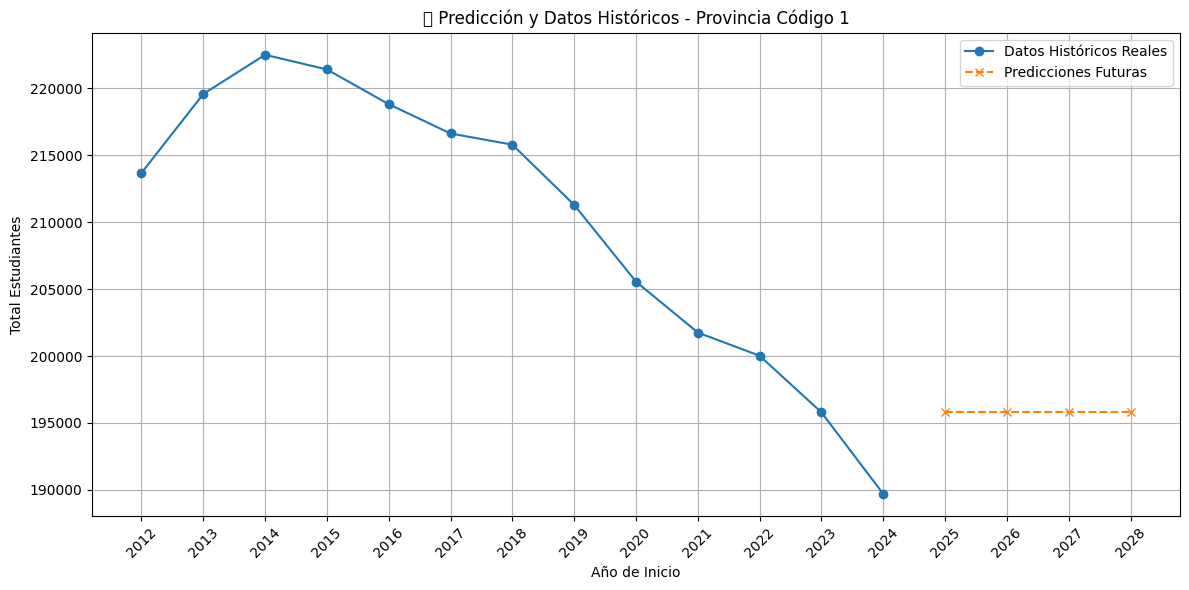

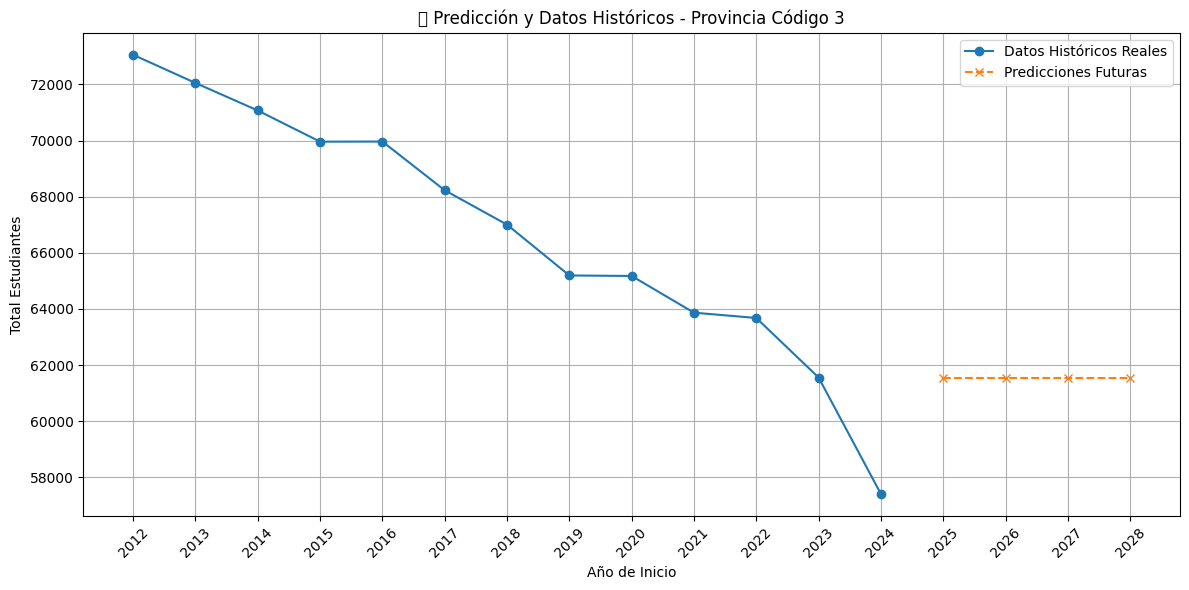

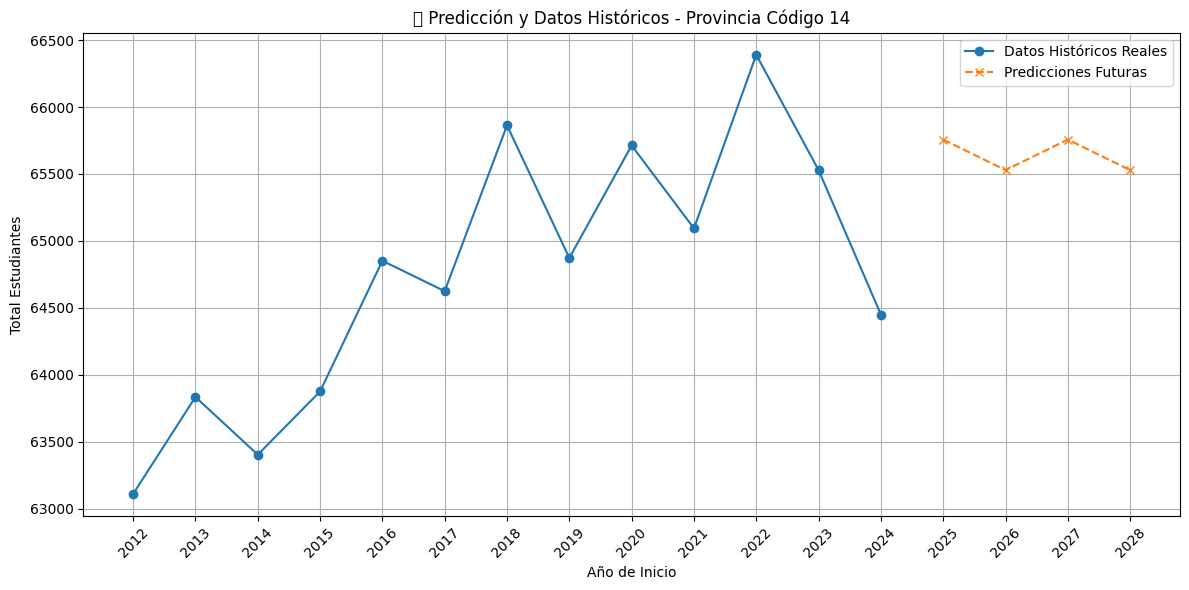

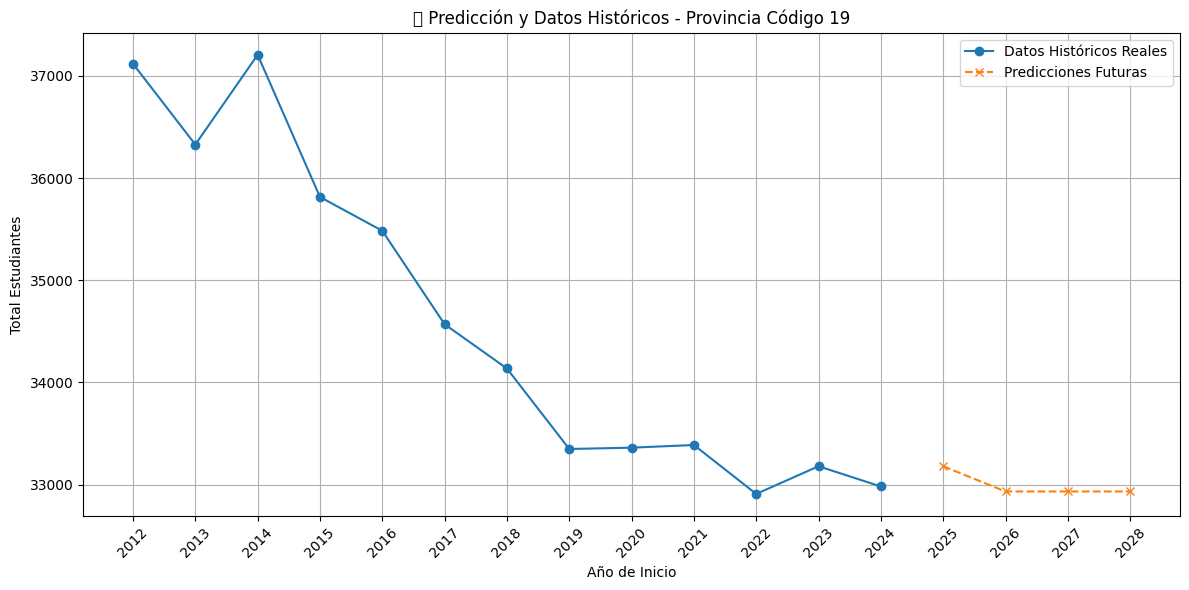

In [29]:
# Seleccionar las provincias de interés
provincias_interes = [1, 3, 14, 19]

# Iterar sobre cada provincia seleccionada para graficar predicciones
for cod_provincia in provincias_interes:
    # Verificar si la provincia existe en los datos de predicciones
    if cod_provincia in all_future_predictions['Cod_Provincia'].unique():

        # Filtrar las predicciones futuras para la provincia actual
        predicciones_prov = all_future_predictions[
            all_future_predictions['Cod_Provincia'] == cod_provincia
        ].copy()

        # Obtener los datos reales de entrenamiento y prueba para esta provincia
        if cod_provincia in province_data_splits:
            splits = province_data_splits[cod_provincia]

            # Combine all X_train and y_train from the windows for historical data
            # We take the initial X_train and concatenate all y_tests as the subsequent real values
            if splits: # Check if the list of splits is not empty
                X_train_prov_hist = splits[0]['X_train'] # Initial training features
                y_train_prov_hist = splits[0]['y_train'] # Initial training targets

                # Collect all real test values (which are the subsequent real values after the initial train set)
                y_test_prov_hist_list = [ventana['y_test'].iloc[0] for ventana in splits]
                # The years for the test data start from the end of the initial training years
                anios_test_hist = [ventana['X_test']['Anio_Inicio'].iloc[0] for ventana in splits]


                # Combine the years and real values for plotting historical data
                anios_train_hist = X_train_prov_hist['Anio_Inicio'].tolist()
                y_train_hist = y_train_prov_hist.tolist()

                # Combine training and historical test years and values
                all_historical_years = anios_train_hist + anios_test_hist
                all_historical_values = y_train_hist + y_test_prov_hist_list


                # Combine all years (historical and future) for x-axis
                all_years = sorted(all_historical_years + predicciones_prov['Anio_Inicio'].tolist())


                # Crear la gráfica
                plt.figure(figsize=(12, 6))

                # Graficar datos históricos reales
                plt.plot(all_historical_years, all_historical_values,
                         label='Datos Históricos Reales', marker='o', linestyle='-')

                # Graficar las predicciones futuras
                plt.plot(predicciones_prov['Anio_Inicio'], predicciones_prov['Total_Estudiantes_Predicho'],
                         label='Predicciones Futuras', marker='x', linestyle='--')

                # Configurar gráfico
                plt.title(f'📈 Predicción y Datos Históricos - Provincia Código {cod_provincia}')
                plt.xlabel('Año de Inicio')
                plt.ylabel('Total Estudiantes')
                plt.xticks(all_years, rotation=45)
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()
            else:
                print(f"⚠️ No hay ventanas de datos para la Provincia Código {cod_provincia}.")


        else:
            print(f"⚠️ No se encontraron datos históricos para la Provincia Código {cod_provincia}.")
    else:
        print(f"❌ No hay predicciones disponibles para la Provincia Código {cod_provincia}.")